In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
#from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:12<00:00, 16.18it/s]


In [ ]:
print(len(lrv_test))

200


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
virus_train_label = np.full(len(virus_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
healthy_train_label = np.full(len(healthy_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
virus_test_label = np.full(len(virus_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
healthy_test_label = np.full(len(healthy_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, virus_train, insect_train, lrv_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, virus_train_label, insect_train_label, lrv_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, virus_test, insect_test, lrv_test,  healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, virus_test_label, insect_test_label, lrv_test_label, healthy_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

ras      = ResNet50(include_top=False, input_shape=input_shape)(inputs)
dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(ras), GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 57217287 (218.27 MB)
Trainable params: 56925895 (217.16 MB)
Non-trainable params: 291392 (1.11 MB)
__________________________________________________________________________________________________


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseVgg16(7_classes)_old.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.7382

136/136 [==============================] - 299s 2s/step - loss: 0.7132 - accuracy: 0.7382 - val_loss: 0.2387 - val_accuracy: 0.9259 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8703

136/136 [==============================] - 193s 1s/step - loss: 0.3539 - accuracy: 0.8703 - val_loss: 0.1177 - val_accuracy: 0.9716 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8899

136/136 [==============================] - 201s 1s/step - loss: 0.2837 - accuracy: 0.8899 - val_loss: 0.0907 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9030

136/136 [==============================] - 201s 1s/step - loss: 0.2557 - accuracy: 0.9030 - val_loss: 0.0442 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9114

136/136 [==============================] - 201s 1s/step - loss: 0.2235 - accuracy: 0.9114 - val_loss: 0.0431 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9158

136/136 [==============================] - 200s 1s/step - loss: 0.2188 - accuracy: 0.9158 - val_loss: 0.1155 - val_accuracy: 0.9597 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9105

136/136 [==============================] - 200s 1s/step - loss: 0.2306 - accuracy: 0.9105 - val_loss: 0.0566 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9240

136/136 [==============================] - 201s 1s/step - loss: 0.1985 - accuracy: 0.9240 - val_loss: 0.0540 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9254

136/136 [==============================] - 201s 1s/step - loss: 0.2014 - accuracy: 0.9254 - val_loss: 0.0361 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9300

136/136 [==============================] - 201s 1s/step - loss: 0.1811 - accuracy: 0.9300 - val_loss: 0.1242 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9339

136/136 [==============================] - 200s 1s/step - loss: 0.1646 - accuracy: 0.9339 - val_loss: 0.0991 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9261

136/136 [==============================] - 200s 1s/step - loss: 0.1770 - accuracy: 0.9261 - val_loss: 0.0563 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9275

136/136 [==============================] - 201s 1s/step - loss: 0.1779 - accuracy: 0.9275 - val_loss: 0.0367 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9414

136/136 [==============================] - 201s 1s/step - loss: 0.1565 - accuracy: 0.9414 - val_loss: 0.1120 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9364

136/136 [==============================] - 200s 1s/step - loss: 0.1620 - accuracy: 0.9364 - val_loss: 0.0452 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9318

136/136 [==============================] - 192s 1s/step - loss: 0.1658 - accuracy: 0.9318 - val_loss: 0.0535 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9339

136/136 [==============================] - 193s 1s/step - loss: 0.1694 - accuracy: 0.9339 - val_loss: 0.0628 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9400

136/136 [==============================] - 200s 1s/step - loss: 0.1508 - accuracy: 0.9400 - val_loss: 0.0622 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9368

136/136 [==============================] - 192s 1s/step - loss: 0.1575 - accuracy: 0.9368 - val_loss: 0.0843 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9407

136/136 [==============================] - 200s 1s/step - loss: 0.1545 - accuracy: 0.9407 - val_loss: 0.0346 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9423

136/136 [==============================] - 201s 1s/step - loss: 0.1511 - accuracy: 0.9423 - val_loss: 0.0519 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9357

136/136 [==============================] - 193s 1s/step - loss: 0.1597 - accuracy: 0.9357 - val_loss: 0.0801 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9396

136/136 [==============================] - 200s 1s/step - loss: 0.1501 - accuracy: 0.9396 - val_loss: 0.0198 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9426

136/136 [==============================] - 201s 1s/step - loss: 0.1439 - accuracy: 0.9426 - val_loss: 0.0313 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9384

136/136 [==============================] - 201s 1s/step - loss: 0.1549 - accuracy: 0.9384 - val_loss: 0.0249 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9492

136/136 [==============================] - 201s 1s/step - loss: 0.1373 - accuracy: 0.9492 - val_loss: 0.0376 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9487

136/136 [==============================] - 200s 1s/step - loss: 0.1381 - accuracy: 0.9487 - val_loss: 0.0380 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9513

136/136 [==============================] - 201s 1s/step - loss: 0.1277 - accuracy: 0.9513 - val_loss: 0.0639 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.9494

136/136 [==============================] - 201s 1s/step - loss: 0.1304 - accuracy: 0.9494 - val_loss: 0.0610 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9506

136/136 [==============================] - 201s 1s/step - loss: 0.1368 - accuracy: 0.9506 - val_loss: 0.0389 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9545

136/136 [==============================] - 192s 1s/step - loss: 0.1187 - accuracy: 0.9545 - val_loss: 0.0589 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9444

136/136 [==============================] - 201s 1s/step - loss: 0.1380 - accuracy: 0.9444 - val_loss: 0.0654 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9551

136/136 [==============================] - 192s 1s/step - loss: 0.1147 - accuracy: 0.9551 - val_loss: 0.0293 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9501

136/136 [==============================] - 192s 1s/step - loss: 0.1321 - accuracy: 0.9501 - val_loss: 0.0375 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9494

136/136 [==============================] - 200s 1s/step - loss: 0.1274 - accuracy: 0.9494 - val_loss: 0.0366 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9499

136/136 [==============================] - 199s 1s/step - loss: 0.1269 - accuracy: 0.9499 - val_loss: 0.0355 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9568

136/136 [==============================] - 199s 1s/step - loss: 0.1142 - accuracy: 0.9568 - val_loss: 0.0423 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9467

136/136 [==============================] - 191s 1s/step - loss: 0.1338 - accuracy: 0.9467 - val_loss: 0.0251 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9508

136/136 [==============================] - 192s 1s/step - loss: 0.1290 - accuracy: 0.9508 - val_loss: 0.0701 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9517

136/136 [==============================] - 199s 1s/step - loss: 0.1197 - accuracy: 0.9517 - val_loss: 0.0460 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9584

136/136 [==============================] - 199s 1s/step - loss: 0.1129 - accuracy: 0.9584 - val_loss: 0.0517 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9513

136/136 [==============================] - 199s 1s/step - loss: 0.1168 - accuracy: 0.9513 - val_loss: 0.0373 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9570

136/136 [==============================] - 199s 1s/step - loss: 0.1148 - accuracy: 0.9570 - val_loss: 0.0549 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9531

136/136 [==============================] - 202s 1s/step - loss: 0.1175 - accuracy: 0.9531 - val_loss: 0.0463 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9497

136/136 [==============================] - 200s 1s/step - loss: 0.1293 - accuracy: 0.9497 - val_loss: 0.0475 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9632

136/136 [==============================] - 192s 1s/step - loss: 0.1018 - accuracy: 0.9632 - val_loss: 0.0415 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9597

136/136 [==============================] - 200s 1s/step - loss: 0.1028 - accuracy: 0.9597 - val_loss: 0.0667 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9547

136/136 [==============================] - 192s 1s/step - loss: 0.1187 - accuracy: 0.9547 - val_loss: 0.0376 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9595

136/136 [==============================] - 200s 1s/step - loss: 0.1085 - accuracy: 0.9595 - val_loss: 0.0763 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9535

136/136 [==============================] - 192s 1s/step - loss: 0.1234 - accuracy: 0.9535 - val_loss: 0.0215 - val_accuracy: 0.9954 - lr: 1.0000e-04


47/47 [==============================] - 36s 639ms/step
Confusion matrix, without normalization
[[204   0   0   0   0   0   2]
 [  0 278   0   0   0   0   0]
 [  0   1 199   0   0   0   0]
 [  0   0   0 200   0   0   0]
 [  0   0   0  16 182   8   0]
 [  0   0   0   0   0 200   0]
 [  3   0   0   0   0   0 202]]


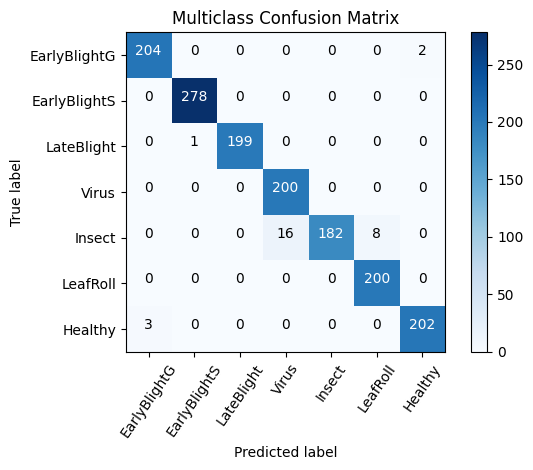

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Virus' , 'Insect','LeafRoll', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

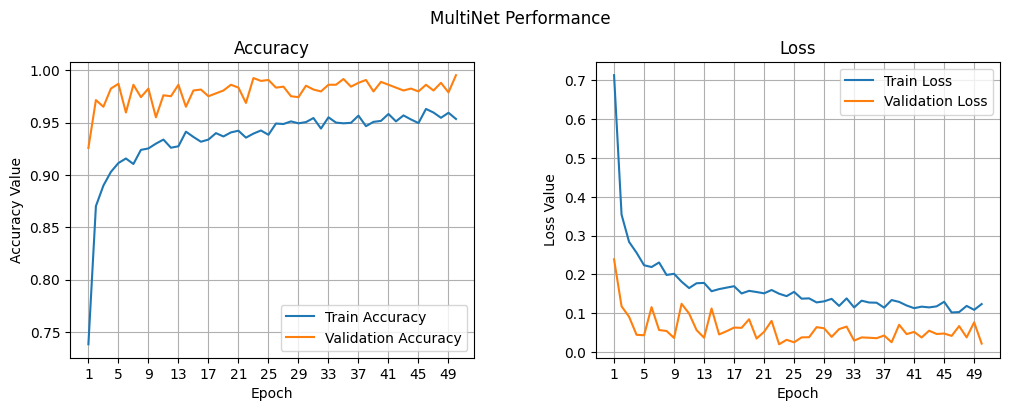

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight','Virus' , 'Insect','LeafRoll','Healthy' ]
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 17s 357ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       0.99      0.99      0.99       206
EarlyBlight Serious       1.00      1.00      1.00       278
         LateBlight       1.00      0.99      1.00       200
              Virus       0.93      1.00      0.96       200
             Insect       1.00      0.88      0.94       206
           LeafRoll       0.96      1.00      0.98       200
            Healthy       0.99      0.99      0.99       205

           accuracy                           0.98      1495
          macro avg       0.98      0.98      0.98      1495
       weighted avg       0.98      0.98      0.98      1495



In [ ]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MultiNet(ResNet50,DenseNet201,VGG16)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 17s 366ms/step
MultiNet(ResNet50,DenseNet201,VGG16)
Accuracy: 0.979933110367893
F1 Score: 0.9801716113902558
precision: 0.9818100614804894
recall: 0.979933110367893
MSE: 0.13712374581939799
MAE: 0.03678929765886288


In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 17s 363ms/step


In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=6)
auc=metrics.auc(fpr, tpr)
auc

0.9857591227075061

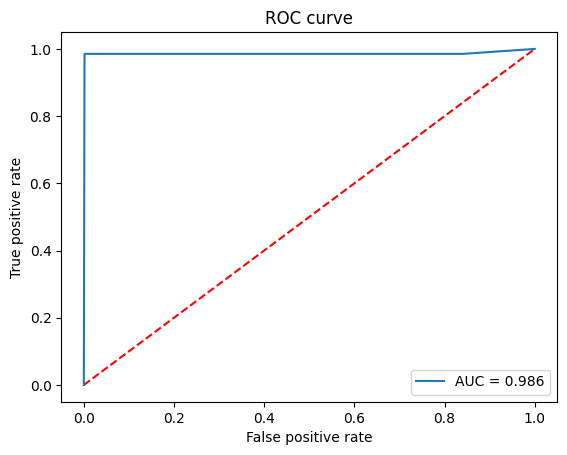

In [ ]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()


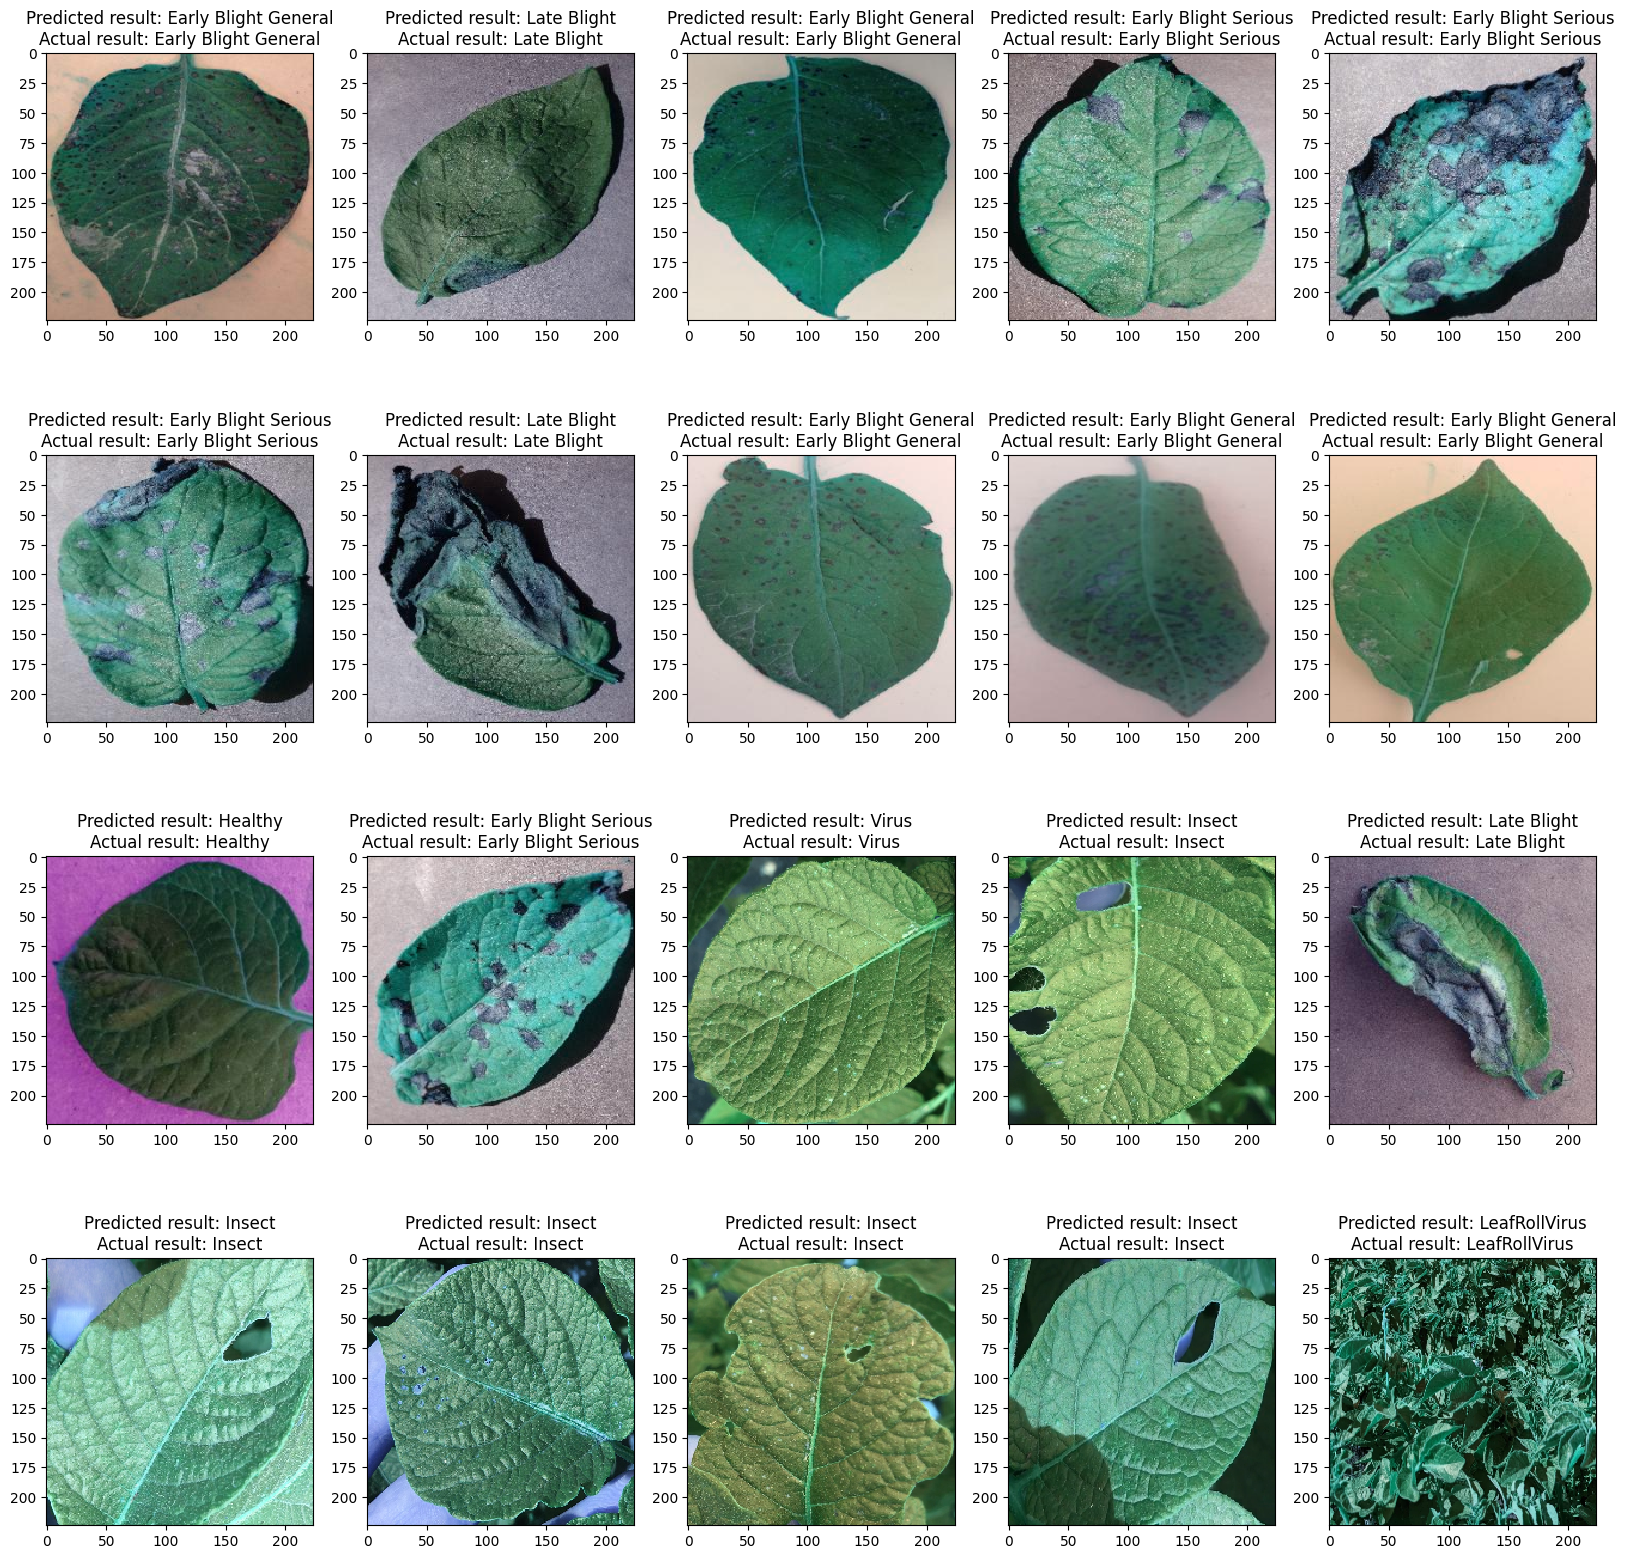

In [ ]:
i = 0
prop_class = []
mis_class = []

for i in range(len(y_val)):
    if np.argmax(y_val[i]) == np.argmax(Y_pred[i]):
        prop_class.append(i)
    if len(prop_class) == 20:
        break

i = 0
for i in range(len(y_val)):
    if not np.argmax(y_val[i]) == np.argmax(Y_pred[i]):
        mis_class.append(i)
    if len(mis_class) == 20:
        break

# Display first 25 images
w = 60
h = 40
fig = plt.figure(figsize=(20, 20))
columns = 5
rows = 4

def transfer_name(name_code):
    if name_code == 0:
        return "Early Blight General"
    elif name_code == 1:
        return "Early Blight Serious"
    elif name_code == 2:
        return "Late Blight"
    elif name_code == 3:
        return "Virus"
    elif name_code == 4:
        return "Insect"
    elif name_code == 5:
        return "LeafRollVirus"
    else:
        return "Healthy"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title("Predicted result: " + transfer_name(np.argmax(Y_pred[prop_class[i]]))
                 + "\n" + "Actual result: " + transfer_name(np.argmax(y_val[prop_class[i]])))
    plt.imshow(x_val[prop_class[i]], interpolation='nearest')

plt.show()
